In [1]:
# Import neccessary libraries
import pandas as pd
import datetime as dt
import numpy as np

In [2]:
# Read data
df = pd.read_csv('2. BI7_DATASET_R01\Historical_sales.csv')
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
rfm = pd.DataFrame(columns=['customer_id', 'recency', 'frequency', 'monetary'])
df.head(10)

,transaction_id,transaction_date,transaction_time,store_id,staff_id,customer_id,product_id,quantity_sold,unit_price,promo_item_yn
0,390,2022-01-01,7:01:00,5,12,5658,22,2,2.00,N
1,1228,2022-01-01,7:02:00,5,30,5197,22,1,2.00,N
2,1644,2022-01-01,7:03:00,5,12,5247,22,2,2.00,N
3,1338,2022-01-01,7:06:00,5,30,5465,32,2,3.00,N
4,2257,2022-01-01,7:06:00,5,30,5627,22,1,2.00,N
5,2254,2022-01-01,7:07:00,5,30,5340,59,2,4.50,N
6,994,2022-01-01,7:07:00,5,12,5806,61,1,4.75,N
7,1127,2022-01-01,7:09:00,5,30,5073,61,2,4.75,N
8,1490,2022-01-01,7:12:00,5,30,5050,45,1,3.00,N
9,991,2022-01-01,7:18:00,5,26,5224,44,1,2.50,N


In [3]:
# Calculate RFM
#           Calculate R _ Recency
max_day = df['transaction_date'].max() 
print(max_day)
print(max_day)
recency = df.groupby('customer_id')['transaction_date'].max().reset_index()
recency.columns = ['customer_id', 'LastPurchaseDate']
recency['recency'] = (max_day - recency['LastPurchaseDate']).dt.days
recency = recency.drop(columns=['LastPurchaseDate'])
recency.head()

2022-04-29 00:00:00
2022-04-29 00:00:00


,customer_id,recency
0,1,0
1,2,3
2,3,5
3,4,3
4,5,0


In [4]:
#           Caculate F _ Frequency
frequency = df.groupby('customer_id')['transaction_date'].count().reset_index()
frequency.columns = ['customer_id', 'frequency']
frequency.head()

,customer_id,frequency
0,1,92
1,2,242
2,3,361
3,4,95
4,5,71


In [5]:
#           Caculate M _ Monetary
monetary = df[["customer_id", "product_id", "quantity_sold", "unit_price"]]
monetary = monetary.copy()
monetary['monetary'] = monetary['quantity_sold'] * monetary['unit_price']
monetary = monetary.groupby('customer_id')['monetary'].sum().reset_index()
monetary.head()

,customer_id,monetary
0,1,333.00
1,2,1021.65
2,3,2082.15
3,4,314.75
4,5,276.00


In [6]:
#           Export RFM.xlxs file (dataset about RFM of each customer)
rfm = recency.merge(frequency, on='customer_id').merge(monetary, on='customer_id')
rfm.to_excel('RFM.xlsx')
rfm.head()

,customer_id,recency,frequency,monetary
0,1,0,92,333.00
1,2,3,242,1021.65
2,3,5,361,2082.15
3,4,3,95,314.75
4,5,0,71,276.00


In [7]:
# Import neccessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

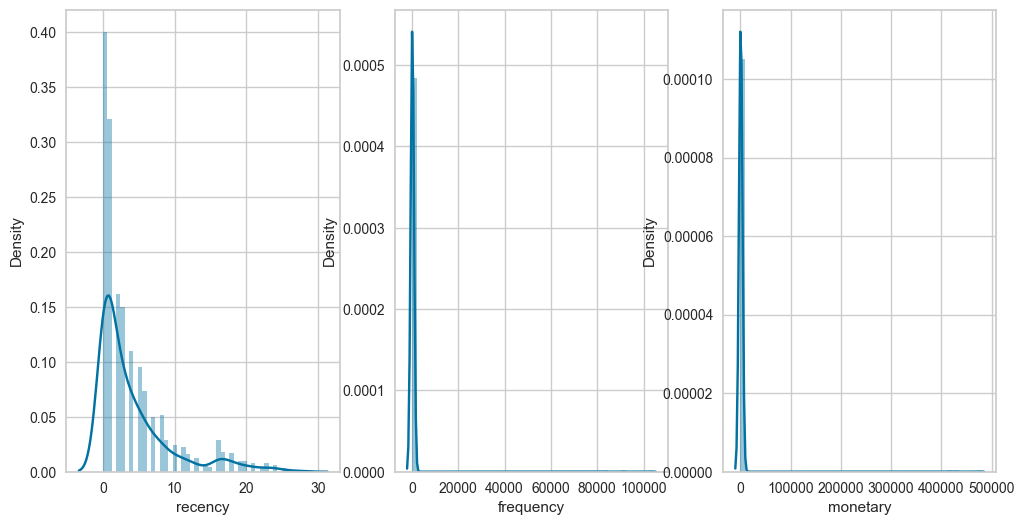

In [8]:
# Check normal distribution
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
sns.distplot(rfm['recency'], ax=ax[0])
sns.distplot(rfm['frequency'], ax=ax[1])
sns.distplot(rfm['monetary'], ax=ax[2])
plt.show()

In [9]:
# Anylyze skewness to find suitable transformation of unnormal dataset
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(rfm[x], ax=ax[0,0])
    sns.distplot(np.log(rfm[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(rfm[x].skew().round(2))
    print(np.log(rfm[x]).skew().round(2))
    print(np.sqrt(rfm[x]).skew().round(2))
    print(pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

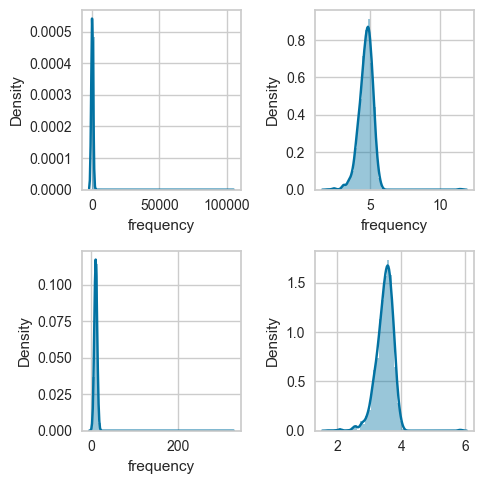

27.66
1.83
25.4
-0.27


In [10]:
analyze_skewness('frequency')

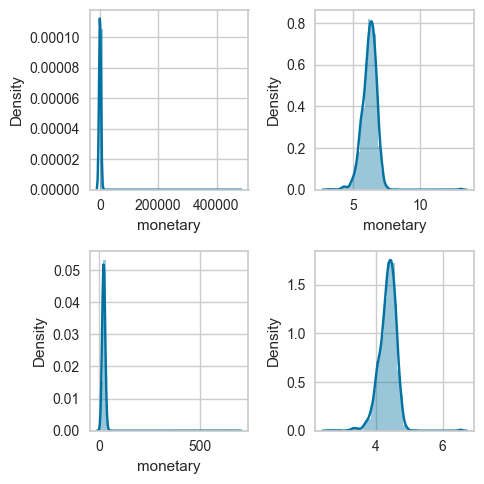

27.48
1.54
25.13
-0.23


In [11]:
analyze_skewness('monetary')

In [12]:
# Normalize frequency and monetary by using boxcox, recency by using sqrt
normalized_rfm = pd.DataFrame()
normalized_rfm['recency'] = np.sqrt(rfm['recency'])
normalized_rfm['frequency'] = stats.boxcox(rfm['frequency'])[0]
normalized_rfm['monetary'] = stats.boxcox(rfm['monetary'])[0]
normalized_rfm.head(10)

,recency,frequency,monetary
0,0.000000,3.387687,4.166452
1,1.732051,3.881300,4.683920
2,2.236068,4.067381,4.977800
3,1.732051,3.405115,4.138527
4,0.000000,3.244168,4.072689
5,2.828427,3.606190,4.373216
6,1.000000,3.516436,4.443240
7,1.732051,3.579491,4.470132
8,1.732051,3.591126,4.467299
9,0.000000,3.542702,4.366199


In [13]:
# Scale RFM dataset
rfm_onlyRFM=rfm[['recency','frequency','monetary']]
scaler = StandardScaler()
scaled_rfm = scaler.fit(normalized_rfm)
scaled_rfm = scaler.fit_transform(normalized_rfm)

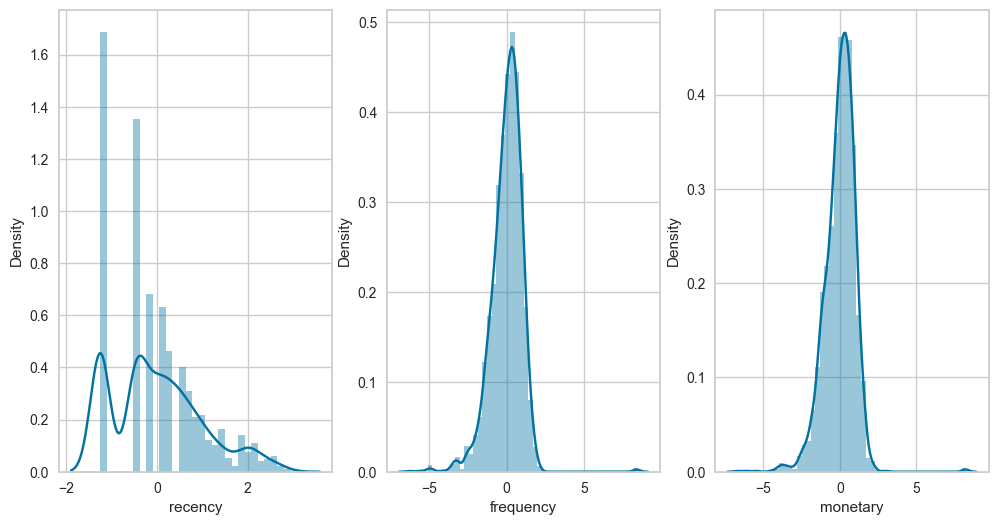

,recency,frequency,monetary
0,-1.244090,-0.325985,-0.712572
1,0.125809,1.425232,1.236649
2,0.524442,2.085401,2.343651
3,0.125809,-0.264154,-0.817762
4,-1.244090,-0.835155,-1.065763
5,0.992946,0.449210,0.066276
6,-0.453179,0.130784,0.330044
7,0.125809,0.354489,0.431344
8,0.125809,0.395766,0.420672
9,-1.244090,0.223969,0.039842


In [14]:
# RFM normalizing and scaling is successful
scaled_rfm1 = pd.DataFrame(scaled_rfm, columns=['recency', 'frequency', 'monetary'])
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
sns.distplot(scaled_rfm1['recency'], ax=ax[0])
sns.distplot(scaled_rfm1['frequency'], ax=ax[1])
sns.distplot(scaled_rfm1['monetary'], ax=ax[2])
plt.show()
scaled_rfm1.head(10)

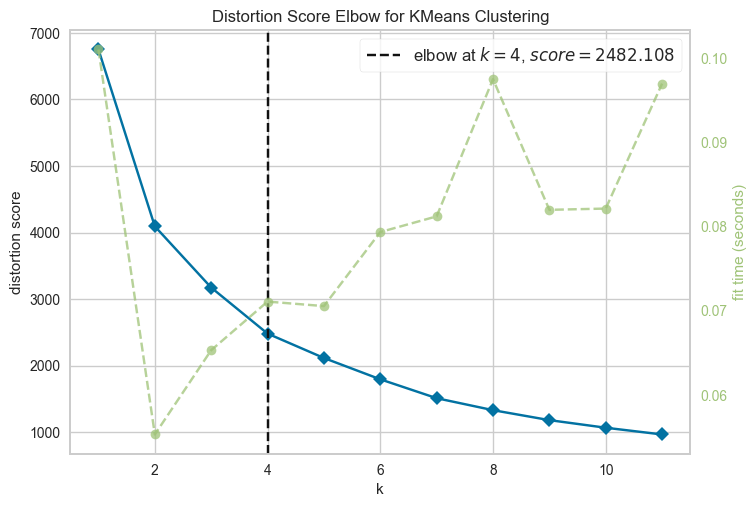

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Applys scaled RFM dataset into K-Means model, determine k by using elbow method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(scaled_rfm)  
visualizer.show()

In [16]:
# Fit model and assign suitable cluster to each customer 
model = KMeans(n_clusters=4, random_state=42)
model.fit(scaled_rfm)
rfm['cluster'] = model.labels_
rfm.head(10)

,customer_id,recency,frequency,monetary,cluster
0,1,0,92,333.00,1
1,2,3,242,1021.65,3
2,3,5,361,2082.15,3
3,4,3,95,314.75,1
4,5,0,71,276.00,1
5,6,8,139,511.80,0
6,7,1,117,595.10,3
7,8,3,132,631.05,0
8,9,3,135,627.15,0
9,10,0,123,504.20,1


In [17]:
# Calculate mean of R-F-M of each cluster
rfm.groupby('cluster').agg(
    {
        'recency':'mean',
        'frequency':'mean',
        'monetary':'mean'
    }
).round(2)

,recency,frequency,monetary
cluster,,,
0,7.35,118.38,536.03
1,0.88,86.13,379.34
2,12.42,48.80,210.63
3,1.43,514.00,2437.29


In [18]:
# Determine suitable type of customer
rfm['cluster'].replace({3: 'Loyal', 0: 'At risk', 1: 'New', 2: 'Lost'}, inplace=True)
rfm.rename(columns={'cluster': 'category'}, inplace=True)
rfm.to_excel('RFM_customer_categories.xlsx')
rfm.head(10)

,customer_id,recency,frequency,monetary,category
0,1,0,92,333.00,New
1,2,3,242,1021.65,Loyal
2,3,5,361,2082.15,Loyal
3,4,3,95,314.75,New
4,5,0,71,276.00,New
5,6,8,139,511.80,At risk
6,7,1,117,595.10,Loyal
7,8,3,132,631.05,At risk
8,9,3,135,627.15,At risk
9,10,0,123,504.20,New


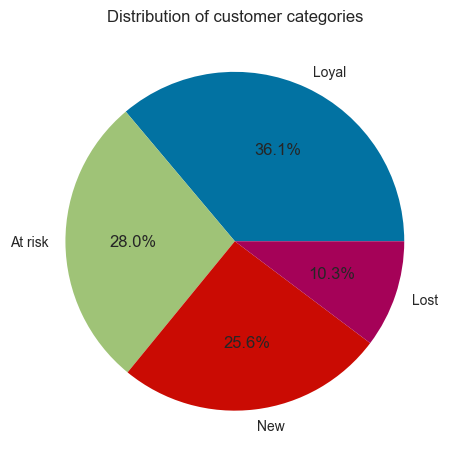

category
Loyal      813
At risk    629
New        577
Lost       231
Name: count, dtype: int64

In [19]:
# Calculate the count of each type of customer
category_counts = rfm['category'].value_counts()

# Plot the pie chart to show percentage of each category
fig, ax = plt.subplots()
ax.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
ax.set_title('Distribution of customer categories')
plt.show()
category_counts.head()